In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    GradientBoostingClassifier
)

from sklearn.linear_model import (SGDClassifier)

from sklearn.model_selection import cross_val_score, TimeSeriesSplit

from xgboost import XGBClassifier

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [2]:
processed = '../data/processed'
main_data = pd.read_pickle(Path(processed) / 'main_data.pkl')

In [3]:
main_data = main_data[(main_data.b_prev_G > 50)]

x_vars = [
    'spot', 'home', 'b_pred_HPPA', 'p_pred_HPAB', 'park_factor', 'year',
    'BAT_HAND', 'PIT_HAND', 'b_avg_win', 'own_p_pred_HPAB',
    'p_team_HPG', 'p_team_avg_game_score', 'rating_rating_pre',
    'rating_rating_prob', 'rating_pitcher_rgs',
    'rating_own_rating_pre', 'rating_own_pitcher_rgs'
]
y_var = ['Win']
vars = x_vars + y_var

main_data = main_data.loc[:, vars]
main_data = main_data.dropna()

train = main_data[(main_data.year < 2000) & (main_data.year >= 1960)]
test = main_data[(main_data.year >= 2000)]

train_x = train[x_vars]
train_y = train['Win'].astype('int')
test_x = test[x_vars]
test_y = test['Win'].astype('int')

In [4]:
preprocessor =  ColumnTransformer(
    [('spot', 'passthrough', x_vars)],
    remainder='drop'
)

sgd = SGDClassifier(
    loss='log',
    penalty='l1',
    random_state=0,
    max_iter = 1000,
    alpha = .0005, 
)

clf = XGBClassifier(
    tree_method='hist',
    verbosity = 0,
    random_state = 0,
    eval_metric = 'auc',
    max_depth = 5,
    learning_rate = .03,
    early_stopping_rounds=5,
    n_estimators = 200,
    subsample=0.9,
    colsample_bynode=0.33,
    use_label_encoder=False,
)

fitted_model = Pipeline([
    ('select', preprocessor),
    ('poly', PolynomialFeatures(2, interaction_only=True)),
    ('scale', StandardScaler()),
    ('feature_selection', SelectFromModel(sgd)),
    ('clf', clf),
])

params = {
    'clf__max_depth': [3, 4],
    "clf__learning_rate": [.03, .02, .01, .001],
    "feature_selection__estimator__alpha": [.0001, .0003, .00001, .000001],
}

inner_cv = StratifiedKFold(shuffle = True, random_state=1)
gs = HalvingGridSearchCV(
    fitted_model, params, refit='AUC', cv=inner_cv,
    scoring='roc_auc',
)

In [5]:
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
outer_cv = StratifiedKFold(shuffle=True, random_state=1)
results = cross_val_score(gs, train, train['Win'].astype('int'), cv=outer_cv, n_jobs=-1, scoring='roc_auc')
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[0.56741903 0.56797789 0.56838845 0.56988215 0.56855196]
Accuracy: 56.844% (0.082%)


In [6]:
gs = HalvingGridSearchCV(
    fitted_model, params, refit='AUC', cv=inner_cv,
    scoring='roc_auc', n_jobs=-1
)
gs.fit(train, train['Win'].astype('int'))

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                    estimator=Pipeline(steps=[('select',
                                               ColumnTransformer(transformers=[('spot',
                                                                                'passthrough',
                                                                                ['spot',
                                                                                 'home',
                                                                                 'b_pred_HPPA',
                                                                                 'p_pred_HPAB',
                                                                                 'park_factor',
                                                                                 'year',
                                                                                 'BAT_HAND',
                              

In [7]:
y_pred = gs.predict_proba(test)[:, 1]
y_true = test['Win'].astype('int')
print(roc_auc_score(y_true, y_pred))

0.5661121282552662


In [8]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)

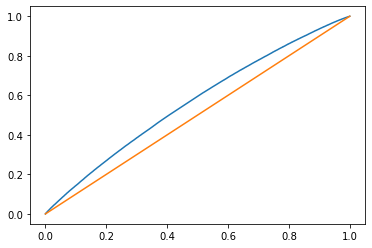

In [9]:
plt.plot(fpr, tpr, tpr, tpr)

In [10]:
# mask = gs.named_steps['feature_selection'].get_support()

# new_features = []
# for bool, feature in zip(mask, x_vars):
#     if bool:
#         new_features.append(feature)
  

# print(new_features)
# import numpy as np
# perc = round(np.sqrt(len(new_features)) / len(new_features), 2)
# print(str(perc*100) + '%')

In [11]:
grid_results = gs.cv_results_

In [12]:
AUC = grid_results['mean_test_score']
AUC

array([0.56149502, 0.56226265, 0.56230906, 0.56183772, 0.55947145,
       0.56012545, 0.55918477, 0.56021065, 0.56231091, 0.56354195,
       0.56272055, 0.56265225, 0.56101054, 0.5620342 , 0.56101894,
       0.56055543, 0.56301049, 0.56337083, 0.56305435, 0.56262117,
       0.56195363, 0.56308309, 0.562498  , 0.56173124, 0.56209792,
       0.56305725, 0.56130984, 0.56103743, 0.56249142, 0.56320809,
       0.56135832, 0.5611587 , 0.56783257, 0.56745278, 0.56814136,
       0.56830422, 0.56568994, 0.56766403, 0.56472548, 0.56654294,
       0.56563526, 0.56622209, 0.56700633, 0.5681054 , 0.56855766,
       0.56919309, 0.56905892, 0.56834045, 0.56866099])

learning_rate


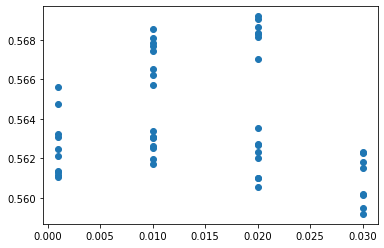

max_depth


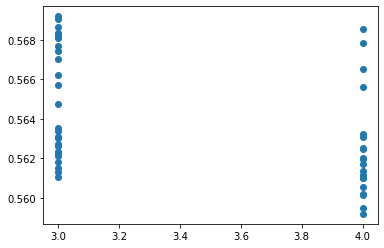

param_feature_selection__estimator__alpha


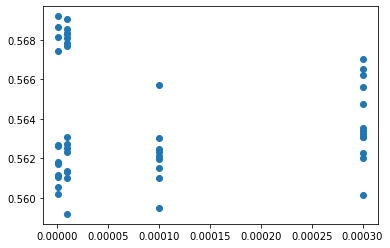

{'learning_rate': array([0.03 , 0.03 , 0.03 , 0.03 , 0.03 , 0.03 , 0.03 , 0.03 , 0.02 ,
        0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.01 , 0.01 ,
        0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.001, 0.001, 0.001,
        0.001, 0.001, 0.001, 0.001, 0.001, 0.01 , 0.01 , 0.02 , 0.02 ,
        0.01 , 0.01 , 0.001, 0.01 , 0.001, 0.01 , 0.02 , 0.01 , 0.01 ,
        0.02 , 0.02 , 0.02 , 0.02 ]),
 'max_depth': array([3., 3., 3., 3., 4., 4., 4., 4., 3., 3., 3., 3., 4., 4., 4., 4., 3.,
        3., 3., 3., 4., 4., 4., 4., 3., 3., 3., 3., 4., 4., 4., 4., 4., 3.,
        3., 3., 3., 3., 3., 4., 4., 3., 3., 3., 4., 3., 3., 3., 3.]),
 'param_feature_selection__estimator__alpha': array([1.e-04, 3.e-04, 1.e-05, 1.e-06, 1.e-04, 3.e-04, 1.e-05, 1.e-06,
        1.e-04, 3.e-04, 1.e-05, 1.e-06, 1.e-04, 3.e-04, 1.e-05, 1.e-06,
        1.e-04, 3.e-04, 1.e-05, 1.e-06, 1.e-04, 3.e-04, 1.e-05, 1.e-06,
        1.e-04, 3.e-04, 1.e-05, 1.e-06, 1.e-04, 3.e-04, 1.e-05, 1.e-06,
        1.e-05, 1.e-06

In [13]:
param_dict = {}
for key, value in grid_results.items():
    if 'param_clf__' in key:
        name = key.replace('param_clf__', '')
        new = np.array(np.ma.getdata(grid_results[key]), dtype=np.float)
        param_dict[name] = new
        print(name)
        plt.figure()
        plt.scatter(new, AUC)
        plt.show()

    if 'param_feature_selection__' in key:
        name = key.replace('param_clf__', '')
        new = np.array(np.ma.getdata(grid_results[key]), dtype=np.float)
        param_dict[name] = new
        print(name)
        plt.figure()
        plt.scatter(new, AUC)
        plt.show()

param_dict

In [14]:
print("Best: %f using %s" % (gs.best_score_, 
    gs.best_params_))

Best: 0.568661 using {'clf__learning_rate': 0.02, 'clf__max_depth': 3, 'feature_selection__estimator__alpha': 1e-06}
